# CaixaBank Tech Hackathon
Autor: Carlos Pérez Ricardo

Sobre mí: Ingeniero aeroespacial con interés y curiosidad en el potencial que tienen los datos. Actualmente, trabajando como Data Scientist en Grupo Hotusa desarrollando diferentes proyectos de Machine Learning (dynamic pricing (estimación de revenue, ocupación, potencial de venta...), reservation cancellation prediction, clasificación de reviews con BERT y algunos otros).

In [1]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 

import random

# Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Evaluation metrics
# Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

# Classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset
Para el reto se emplearán valores históricos del IBEX35 desde el año 1994 en periodos de un día.
Estos datos se representan por velas japonesas.

Estas indican:

- El precio de apertura de un valor.
- El precio de cierre de un valor.
- El máximo y el mínimo que ha encontrado ese valor.

En esta hackathon se trabajará con tres datasets que contienen datos históricos del IBEX35: train.csv , test_x.csv y tweets_from2015_#Ibex35.csv

train.csv: Contiene datos históricos y el target a predecir.

tweets_from2015_#Ibex35.csv: Contiene los tweets públicos que contienen el hashtag #Ibex35 desde el año 2015 que han recibido más de dos likes y de dos retweets.

test_x.csv: Contiene tan solo las variables predictoras. Este dataset se empleará como input para tu modelo predictivo.

Las variables predictoras que se presentan son:

- Date: Día al que hacen referencia los datos presentados.
- Open: Precio de apertura de ese día.
- High: Precio máximo alcanzado durante ese día.
- Low: Precio mínimo alcanzado durante ese día.
- Close: Precio de cierre de ese día ajustado por splits.
- Adj Close: Precio de cierre ajustado por splits y distribuciones de dividendos o plusvalías.
- Volume: El número físico de acciones negociadas del índice bursátil.

La variable objetivo:

- Target: Esta es la variable a predecir. Es una variable binaria.

  * 1: Indica que el precio de cierre tres días adelante será más alto que el precio de cierre actual.
  * 0: Indica que el precio de cierre tres días adelante será igual o menor al precio actual.

# Reto
Desarrolla un modelo predictivo que permita predecir la variable target (si el precio de cierre del IBEX35 será superior o inferior al precio de cierre actual).
Para ello deberas entrenar tu modelo con los datos de training (si también se usan los tweets se sumaran 100 puntos) e introducir como input de tu modelo el dataset test_x para realizar las predicciones.

Crea un breve documento (máx. 2 páginas) o presentación (máx. 4 slides) explicando la solución que has empleado y porque la has empleado.

# Evaluación
La evaluación se basará en:

- 800/1200:(OBJECTIVES) Se obtendrá a partir de la métrica f1-score(macro) del modelo de predicción. Comparando las predicciones que tu modelo ha hecho sobre test_x frente al ground truth.

- 100/1200:(OBJECTIVES) Si eres capaz de incorporar la información de los tweets a tu modelo predictivo, se recompensara con 100 puntos extra.

- 100/1200:(DOC) Breve presentación explicando lo que has hecho y cómo lo has hecho.

- 200/1200:(QUALITY) Calidad del código.

In [3]:
train = pd.read_csv('/content/train.csv', parse_dates = ['Date'])
test = pd.read_csv('/content/test_x.csv', parse_dates = ['Date'], index_col = 0)

In [4]:
train.shape

(6554, 8)

In [5]:
test.shape

(726, 7)

In [6]:
train.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
5,1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
6,1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
7,1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1
8,1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1
9,1994-01-14,3680.800049,3737.399902,3662.899902,3736.399902,3736.395996,0.0,1


In [7]:
test.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
test_index,,,,,,,
6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0


In [8]:
train.describe()

,Open,High,Low,Close,Adj Close,Volume,Target
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,6.421000e+03,6554.000000
mean,8936.540448,9005.235576,8858.340567,8934.978558,8934.970624,8.218074e+07,0.516936
std,2732.102441,2749.009324,2712.511028,2731.032625,2731.030170,1.231845e+08,0.499751
min,2865.100098,2877.300049,2833.600098,2865.100098,2865.097168,0.000000e+00,0.000000
25%,7732.399902,7817.200195,7641.500000,7727.799805,7727.791992,0.000000e+00,0.000000
50%,9329.700195,9404.599609,9243.000000,9331.000000,9331.000000,1.966000e+05,1.000000
75%,10525.500000,10590.299805,10441.200195,10523.400391,10523.400391,1.773980e+08,1.000000
max,15999.200195,16040.400391,15868.599609,15945.700195,15945.683594,7.894902e+08,1.000000


In [9]:
train.isnull().sum()

Date           0
Open         133
High         133
Low          133
Close        133
Adj Close    133
Volume       133
Target         0
dtype: int64

In [10]:
train[train.isnull().sum(axis=1) != 0]

,Date,Open,High,Low,Close,Adj Close,Volume,Target
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
64,1994-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0
65,1994-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0
85,1994-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0
202,1994-10-12,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
3125,2005-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0
3385,2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0
3637,2007-12-24,NaN,NaN,NaN,NaN,NaN,NaN,0
4661,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0


Todos los NaNs son filas enteras. Probablemente para ese día no se recogieron datos. 

# Data Understanding 
# Target

Target: Esta es la variable a predecir. Es una variable binaria.

- 1: Indica que el precio de cierre tres días adelante será más alto que el precio de cierre actual.
- 0: Indica que el precio de cierre tres días adelante será igual o menor al precio actual.

In [11]:
train.loc[ train.Date <= '1994-01-20']

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
5,1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
6,1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
7,1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1
8,1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1
9,1994-01-14,3680.800049,3737.399902,3662.899902,3736.399902,3736.395996,0.0,1


Como no tenemos muchos registros, me gustaría poder aprovechar los todos. Como se trata de un problema de Time Series, simplemente rellenaremos los registros nulos con los datos del día anterior (fill forward).

In [12]:
train = train.ffill(axis = 0)

# Solución

Pese a que sea un problema de clasificación tiene un componente de regresión. Queremos averiguar que precio de cierre habrá de aquí 3 días. 

Si el precio de cierre actual tres días adelante es más alto que el precio de cierre actual es VERDADERO. Si es más bajo FALSO.

En realidad es un problema de Series Temporales, pero Series Temporales se simplifican a una Regresión. 

Recordar que la predicción debe hacerse a 3 días vista y que no podemos utilizar datos del futuro en el pasado! Es decir, si queremos saber los datos a 3 días vista no conocemos los datos de +1, +2 o +3 días.

In [13]:
train['range_High_Low'] = train['High'] - train['Low']
train['diff_Open_Close'] = train['Open'] - train['Close']
train['diff_Open_High'] = train['Open'] - train['High']
train['diff_Open_Low'] = train['Open'] - train['Low']

train['Close_orig'] = train['Close']

In [14]:
def apply_shift(df, col, shift):
    df[col+'_s'+str(shift)] = df[col].shift(shift)
    return df

In [15]:
def apply_shift_rolling(df, col, shift, window):
    df[col+'_s'+str(shift)+'_r_'+str(window)+'_mean'] = df[col].shift(shift).rolling(window).mean()
    df[col+'_s'+str(shift)+'_r_'+str(window)+'_std'] = df[col].shift(shift).rolling(window).std()
    df[col+'_s'+str(shift)+'_r_'+str(window)+'_median'] = df[col].shift(shift).rolling(window).median()
    df[col+'_s'+str(shift)+'_r_'+str(window)+'_max'] = df[col].shift(shift).rolling(window).max()
    df[col+'_s'+str(shift)+'_r_'+str(window)+'_min'] = df[col].shift(shift).rolling(window).min()

    return df

In [16]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['month'] = train['Date'].dt.weekday
train['quarter'] = train['Date'].dt.quarter
train['week'] = train['Date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [17]:
shift_cols = ['Open','High','Low','Close','Adj Close','Volume']
for col in shift_cols:
    # Represent all columns in terms of the close of 7 days ago
    # We don't care much about the prediction (we only care if we higher or lower)
    train[col] = train[col] - train['Close'].shift(7) 

    if col == 'Volume':
        train[col] = train[col] - train[col].shift(7) 

    train = apply_shift(train, col, 3)
    train = apply_shift(train, col, 6)
    train = apply_shift(train, col, 9)
    train = apply_shift(train, col, 18)

    train = apply_shift_rolling(train, col, 3, 2)
    train = apply_shift_rolling(train, col, 3, 5)
    train = apply_shift_rolling(train, col, 3, 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented fr

In [18]:
other_cols = ['range_High_Low','diff_Open_Close','diff_Open_High','diff_Open_Low']
for col in other_cols:
    train = apply_shift(train, col, 3)
    train = apply_shift(train, col, 6)
    train = apply_shift(train, col, 9)
    
    train = apply_shift_rolling(train, col, 3, 2)
    train = apply_shift_rolling(train, col, 3, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [19]:
train.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,range_High_Low,diff_Open_Close,...,diff_Open_Low_s3_r_2_mean,diff_Open_Low_s3_r_2_std,diff_Open_Low_s3_r_2_median,diff_Open_Low_s3_r_2_max,diff_Open_Low_s3_r_2_min,diff_Open_Low_s3_r_5_mean,diff_Open_Low_s3_r_5_std,diff_Open_Low_s3_r_5_median,diff_Open_Low_s3_r_5_max,diff_Open_Low_s3_r_5_min
0,1994-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0,73.699951,-39.300049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1,50.399902,24.199951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1,41.800049,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0,41.800049,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1,45.699951,-15.199951,...,31.799927,3.394147,31.799927,34.199951,29.399902,NaN,NaN,NaN,NaN,NaN


In [20]:
train = train.bfill(axis = 0)

In [21]:
# We generate random for Feature Selection with feature importance
# Features with less importance than random variable, do not add any value to the ML model
# Even though, feature importance is tricky for high cardinality (float) features.
# https://www.linkedin.com/posts/damienbenveniste_machinelearning-data-datascience-activity-6935620347069136896-t_IW?utm_source=linkedin_share&utm_medium=member_desktop_web

randomlist = []
for i in range(0,train.shape[0]):
    n = random.uniform(0,1)
    randomlist.append(n)

train['random'] = randomlist

In [22]:
avoid_cols = shift_cols + other_cols

features = [ x for x in train.columns if x not in avoid_cols ]
features.remove('Date')
features.remove('Close_orig')
features.remove('Target')

In [23]:
len(features)

171

In [24]:
train['Date'].min(), train['Date'].max()

(Timestamp('1994-01-03 00:00:00'), Timestamp('2019-05-30 00:00:00'))

In [25]:
#X_train, X_valida, y_train, y_valida = train_test_split(train, train['Close'], test_size=0.3, random_state=42)
#X_train, X_valida, y_train, y_valida = train_test_split(train, train['Target'], test_size=0.2, random_state=42)

date_thres = '2018-05-30'
# Time Series split done correctly
X_train = train.loc[train.Date <= '2018-05-30']
y_train = train.loc[train.Date <= '2018-05-30','Target']
X_valida = train.loc[train.Date > '2018-05-30']
y_valida = train.loc[train.Date > '2018-05-30','Target']

In [26]:
def class_metrics(y_train, y_train_pred, y_train_pred_proba,
                  y_test, y_test_pred, y_test_pred_proba):
    def all_metrics(y, y_pred, y_proba):
        print(' Accuracy: ',accuracy_score(y, y_pred))
        print(' Precision: ',precision_score(y, y_pred))
        print(' Recall: ',recall_score(y, y_pred))
        print(' F1-score :',f1_score(y, y_pred))
        print(' ROC AUC score:', roc_auc_score(y,y_proba))
    print('---- TRAIN ----')
    all_metrics(y_train, y_train_pred, y_train_pred_proba)
    print('---- TEST ----')
    all_metrics(y_test, y_test_pred, y_test_pred_proba)

## Support Vector Machine

In [27]:
svm = make_pipeline(StandardScaler(), SVC())
svm.fit(X_train[features], y_train)

y_train_pred = svm.predict(X_train[features])
y_train_pred_proba = svm.predict(X_train[features])

y_valida_pred = svm.predict(X_valida[features])
y_valida_pred_proba = svm.predict(X_valida[features])

class_metrics(y_train, y_train_pred, y_train_pred_proba, y_valida, y_valida_pred, y_valida_pred_proba)

---- TRAIN ----
 Accuracy:  0.6807429750754088
 Precision:  0.6464788732394366
 Recall:  0.8450444921755139
 F1-score : 0.7325442213060247
 ROC AUC score: 0.6748248776667043
---- TEST ----
 Accuracy:  0.5058823529411764
 Precision:  0.5069767441860465
 Recall:  0.8449612403100775
 F1-score : 0.6337209302325582
 ROC AUC score: 0.5018456995201181


In [28]:
def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

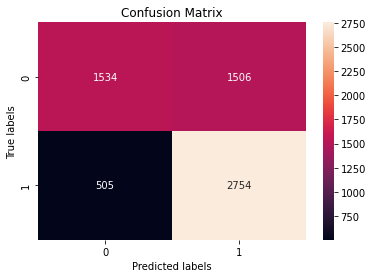

In [29]:
plot_confusion_matrix(y_train, y_train_pred)

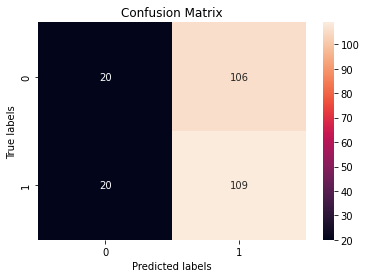

In [30]:
plot_confusion_matrix(y_valida, y_valida_pred)

## Random Forest

In [31]:
rf = RandomForestClassifier(random_state=42, min_samples_split=100, min_samples_leaf=30)
grid_param = {
    'n_estimators': [50,100,150,200],
    'max_depth': [3,4,5,7]
}
gd_sr = GridSearchCV(estimator=rf, # lgbm or rf
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(X_train[features], y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=30,
                                              min_samples_split=100,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7],
                         'n_estimators': [50, 100, 150, 200]})

In [32]:
rf_ = gd_sr.best_estimator_
print(rf_)

y_train_pred = rf_.predict(X_train[features])
y_train_pred_proba = rf_.predict_proba(X_train[features])[:, 1]
y_valida_pred = rf_.predict(X_valida[features])
y_valida_pred_proba = rf_.predict_proba(X_valida[features])[:, 1]

class_metrics(y_train, y_train_pred, y_train_pred_proba, 
              y_valida, y_valida_pred, y_valida_pred_proba)

RandomForestClassifier(max_depth=4, min_samples_leaf=30, min_samples_split=100,
                       random_state=42)
---- TRAIN ----
 Accuracy:  0.6218447372598825
 Precision:  0.589838147920508
 Recall:  0.8833998158944462
 F1-score : 0.7073710073710073
 ROC AUC score: 0.6987259976421569
---- TEST ----
 Accuracy:  0.5372549019607843
 Precision:  0.5224489795918368
 Recall:  0.9922480620155039
 F1-score : 0.6844919786096256
 ROC AUC score: 0.5626307370493416


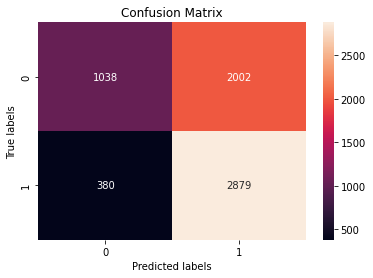

In [33]:
plot_confusion_matrix(y_train, y_train_pred)

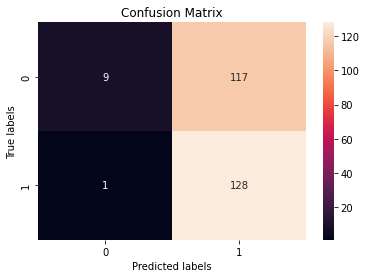

In [34]:
plot_confusion_matrix(y_valida, y_valida_pred)

In [35]:
fp = pd.DataFrame({'feature':features,'feature_imp':rf_.feature_importances_}).sort_values('feature_imp', ascending=False)
fp.head(20)

,feature,feature_imp
146,diff_Open_High_s9,0.022999
133,diff_Open_Close_s9,0.020864
98,Adj Close_s3_r_10_min,0.018140
47,Low_s3_r_2_std,0.017069
106,Volume_s3_r_2_max,0.015903
20,Open_s3_r_10_median,0.015650
110,Volume_s3_r_5_median,0.015396
75,Close_s3_r_10_mean,0.015201
28,High_s3_r_2_std,0.014361
164,diff_Open_Low_s3_r_2_min,0.014301


In [36]:
delete_features = fp[ fp.feature_imp < fp[fp.feature=='random']['feature_imp'].values[0]*0.9 ]
delete_features = delete_features['feature'].to_list()

new_features = [ x for x in features if x not in delete_features ]
new_features.remove('random')

In [37]:
print(len(features))
print(len(new_features))

171
170


In [38]:
gd_sr = GridSearchCV(estimator=rf, # lgmb, rf
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)

In [39]:
gd_sr.fit(X_train[new_features], y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=30,
                                              min_samples_split=100,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7],
                         'n_estimators': [50, 100, 150, 200]})

In [40]:
red_model = gd_sr.best_estimator_
print(red_model)

y_train_pred = red_model.predict(X_train[new_features])
y_train_pred_proba = red_model.predict_proba(X_train[new_features])[:, 1]
y_valida_pred = red_model.predict(X_valida[new_features])
y_valida_pred_proba = red_model.predict_proba(X_valida[new_features])[:, 1]

class_metrics(y_train, y_train_pred, y_train_pred_proba, 
              y_valida, y_valida_pred, y_valida_pred_proba)

RandomForestClassifier(max_depth=7, min_samples_leaf=30, min_samples_split=100,
                       random_state=42)
---- TRAIN ----
 Accuracy:  0.7021749484045087
 Precision:  0.6628208146927242
 Recall:  0.8637618901503529
 F1-score : 0.7500666133759658
 ROC AUC score: 0.8057157507146202
---- TEST ----
 Accuracy:  0.5333333333333333
 Precision:  0.5211864406779662
 Recall:  0.9534883720930233
 F1-score : 0.6739726027397261
 ROC AUC score: 0.5857019810508183


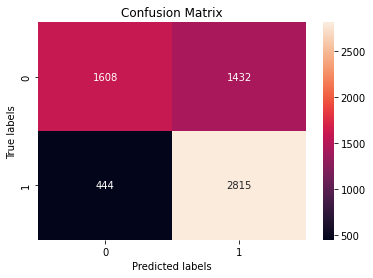

In [41]:
plot_confusion_matrix(y_train, y_train_pred)

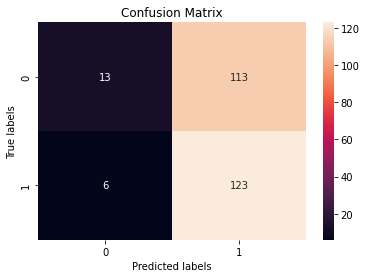

In [42]:
plot_confusion_matrix(y_valida, y_valida_pred)

## LightGBM

In [43]:
lgbm = LGBMClassifier(random_state=42, min_samples_split=50, min_samples_leaf=25)
grid_param = {
    'n_estimators': [30,40,50,70],
    'max_depth': [3,5,7,10]
}
gd_sr = GridSearchCV(estimator=lgbm, # lgbm or rf
                     param_grid=grid_param,
                     cv=7,
                     n_jobs=-1)
gd_sr.fit(X_train[features], y_train)

GridSearchCV(cv=7,
             estimator=LGBMClassifier(min_samples_leaf=25, min_samples_split=50,
                                      random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [30, 40, 50, 70]})

In [44]:
lgbm_ = gd_sr.best_estimator_
print(lgbm_)

y_train_pred = lgbm_.predict(X_train[features])
y_train_pred_proba = lgbm_.predict_proba(X_train[features])[:, 1]
y_valida_pred = lgbm_.predict(X_valida[features])
y_valida_pred_proba = lgbm_.predict_proba(X_valida[features])[:, 1]

class_metrics(y_train, y_train_pred, y_train_pred_proba, 
              y_valida, y_valida_pred, y_valida_pred_proba)

LGBMClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50,
               n_estimators=40, random_state=42)
---- TRAIN ----
 Accuracy:  0.8999841244642006
 Precision:  0.879146235938852
 Recall:  0.9352562135624425
 F1-score : 0.9063336306868868
 ROC AUC score: 0.9648234242018057
---- TEST ----
 Accuracy:  0.5725490196078431
 Precision:  0.5526315789473685
 Recall:  0.813953488372093
 F1-score : 0.6583072100313481
 ROC AUC score: 0.5709979082072105


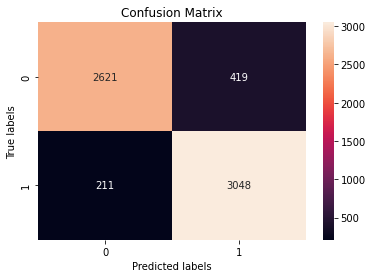

In [45]:
plot_confusion_matrix(y_train, y_train_pred)

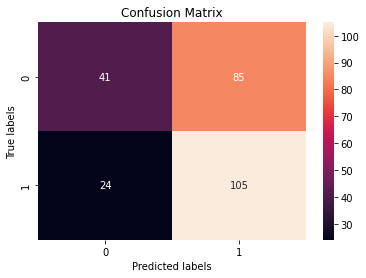

In [46]:
plot_confusion_matrix(y_valida, y_valida_pred)

# Solución Final

In [47]:
def preprocess(df):

    df = df.ffill(axis = 0)

    df['range_High_Low'] = df['High'] - df['Low']
    df['diff_Open_Close'] = df['Open'] - df['Close']
    df['diff_Open_High'] = df['Open'] - df['High']
    df['diff_Open_Low'] = df['Open'] - df['Low']

    df['Close_orig'] = df['Close'].copy()

    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['month'] = df['Date'].dt.weekday
    df['quarter'] = df['Date'].dt.quarter
    df['week'] = df['Date'].dt.week

    shift_cols = ['Open','High','Low','Close','Adj Close','Volume']
    for col in shift_cols:
        # Represent all columns in terms of the close of 7 days ago
        # We don't care much about the prediction (we only care if we higher or lower)
        df[col] = df[col] - df['Close'].shift(7) 

        if col == 'Volume':
            df[col] = df[col] - df[col].shift(7) 

        df = apply_shift(df, col, 3)
        df = apply_shift(df, col, 6)
        df = apply_shift(df, col, 9)
        df = apply_shift(df, col, 18)

        df = apply_shift_rolling(df, col, 3, 2)
        df = apply_shift_rolling(df, col, 3, 5)
        df = apply_shift_rolling(df, col, 3, 10)

    other_cols = ['range_High_Low','diff_Open_Close','diff_Open_High','diff_Open_Low']
    for col in other_cols:
        df = apply_shift(df, col, 3)
        df = apply_shift(df, col, 6)
        df = apply_shift(df, col, 9)
        
        df = apply_shift_rolling(df, col, 3, 2)
        df = apply_shift_rolling(df, col, 3, 5)
    
    randomlist = []
    for i in range(0,df.shape[0]):
        n = random.uniform(0,1)
        randomlist.append(n)
    df['random'] = randomlist

    df = df.bfill(axis = 0)

    avoid_cols = shift_cols + other_cols

    features = [ x for x in df.columns if x not in avoid_cols ]
    features.remove('Date')
    features.remove('Close_orig')
    features.remove('TRAIN_TEST')
    features.remove('Target')

    return df, features

In [48]:
train = pd.read_csv('/content/train.csv', parse_dates = ['Date'])
test = pd.read_csv('/content/test_x.csv', parse_dates = ['Date'], index_col = 0)

train['TRAIN_TEST'] = 0
test['TRAIN_TEST'] = 1

train_test = pd.concat([train, test], axis=0)

train_test, features = preprocess(train_test)

if True:
    train_test['Close_orig_f3'] = train_test['Close_orig'].shift(-3)
    train_test['Target_'] = train_test['Close_orig_f3'] > train_test['Close_orig']
    train_test['Target_'] = train_test['Target_'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: Dat

In [49]:
train_test[['Date','Close_orig','Close_orig_f3','Target','Target_']].sample(10)

,Date,Close_orig,Close_orig_f3,Target,Target_
371,1995-06-06,3261.500000,3242.800049,0.0,0
5966,2017-02-07,9331.500000,9378.099609,1.0,1
7273,2022-03-18,8417.599609,8328.400391,0.0,0
6669,2019-11-08,9393.700195,9194.500000,0.0,0
6817,2020-06-10,7663.899902,7259.299805,0.0,0
4545,2011-07-21,10017.599609,9833.400391,0.0,0
4256,2010-06-07,8795.299805,9198.200195,1.0,1
7096,2021-07-12,8816.700195,8527.000000,0.0,0
114,1994-06-10,3495.699951,3399.600098,0.0,0
4378,2010-11-24,9742.599609,9324.700195,0.0,0


In [50]:
X_train = train_test.loc[train_test.TRAIN_TEST == 0]
y_train = train_test.loc[train_test.TRAIN_TEST == 0, 'Target'].astype(int).astype('category')

X_test = train_test.loc[train_test.TRAIN_TEST == 1]
y_test = train_test.loc[train_test.TRAIN_TEST == 1, 'Target_'].astype(int).astype('category')

In [51]:
#best_model = make_pipeline(StandardScaler(), SVC())

best_model = RandomForestClassifier(max_depth=4, min_samples_leaf=30, min_samples_split=100,
                       n_estimators=50, random_state=42)

best_model.fit(X_train[features], y_train)

y_train_pred = best_model.predict(X_train[features])
y_train_pred_proba = best_model.predict_proba(X_train[features])[:, 1]
y_test_pred = best_model.predict(X_test[features])
y_test_pred_proba = best_model.predict_proba(X_test[features])[:, 1]

class_metrics(y_train, y_train_pred, y_train_pred_proba, 
              y_valida, y_valida_pred, y_valida_pred_proba)

---- TRAIN ----
 Accuracy:  0.617485505035093
 Precision:  0.5865252406207032
 Recall:  0.8813459268004723
 F1-score : 0.7043283406062036
 ROC AUC score: 0.6877920362529563
---- TEST ----
 Accuracy:  0.5725490196078431
 Precision:  0.5526315789473685
 Recall:  0.813953488372093
 F1-score : 0.6583072100313481
 ROC AUC score: 0.5709979082072105


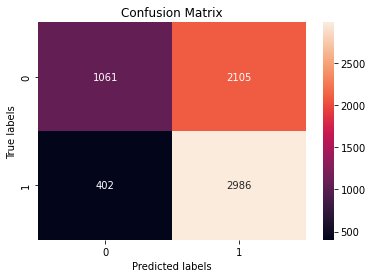

In [52]:
plot_confusion_matrix(y_train, y_train_pred)

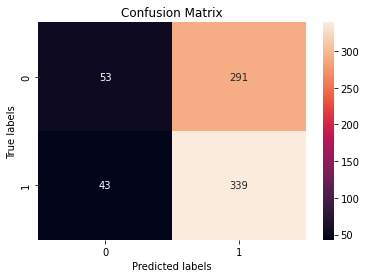

In [53]:
plot_confusion_matrix(y_test, y_test_pred)

In [54]:
test = pd.read_csv('/content/test_x.csv', parse_dates = ['Date'])
test['pred'] = y_test_pred
test[['test_index','pred']].to_csv('prediction.csv')
test[['test_index','pred']].to_json('prediction.json')

# Extra: LTSM

He probado con Long short-term memory (LSTM). Se trata de un problema donde interesa memorizar y conocer que ha pasado anteriormente. 

No estoy seguro si se respeta tan sólo utilizar datos del pasado, al entrenar el modelo en batches de timesteps.


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import time

import keras
from tensorflow import keras as ks

from keras.layers import TimeDistributed
from keras.models import load_model
from keras.layers import Dense, LSTM, BatchNormalization

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.callbacks import ModelCheckpoint

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [56]:
df_train = pd.read_csv('/content/train.csv', parse_dates=['Date'])
df_test = pd.read_csv('/content/test_x.csv', parse_dates=['Date'], index_col=0)

In [57]:
df_train['Date'].max()

Timestamp('2019-05-30 00:00:00')

In [58]:
# Compute test_target 
df_train['TRAIN_TEST'] = 0
df_test['TRAIN_TEST'] = 1

train_test = pd.concat([df_train, df_test], axis=0)

if False:
    train_test['Close_f3'] = train_test['Close'].shift(-3)
    train_test['Target_'] = train_test['Close_f3'] > train_test['Close']
    train_test['Target_'] = train_test['Target_'].astype(int)

In [59]:
def convert_time(df):
    df = df.ffill(axis = 0)
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['month'] = df['Date'].dt.weekday
    df['quarter'] = df['Date'].dt.quarter
    df['week'] = df['Date'].dt.week

    return df

In [60]:
def convert_to_int(df):
    shift_cols = ['Open','High','Low','Close','Adj Close','Volume']
    for col in shift_cols:
        # Represent all columns in terms of the close of 7 days ago
        # We don't care much about the prediction (we only care if we higher or lower)
        if col != 'Volume':
            df[col] = df[col]*1000
            #df[col] = df[col] - df['Close'].shift(7) 
        df[col] = df[col].astype(int)
    
    return df

In [61]:
train_test = convert_time(train_test)
train_test = convert_to_int(train_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [62]:
cols = train_test.columns
cols = cols.drop("Target")
cols = cols.drop("TRAIN_TEST")
cols = cols.drop("Date")
try:
    del train_test['Close_f3']
    del train_test['Target_']
except:
    pass

X_train = train_test.loc[train_test.Date <='2019-05-30',cols]
y_train = train_test.loc[train_test.Date <='2019-05-30','Target']

X_test = train_test.loc[train_test.Date >'2019-05-30',cols]
y_test = train_test.loc[train_test.Date >'2019-05-30','Target']

y_test = y_test.astype(int).astype('category')
y_train = y_train.astype(int).astype('category')

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
X_train.shape, X_test.shape

((6554, 10), (726, 10))

In [65]:
X_train.shape[0]/29

226.0

In [66]:
#[samples, timesteps, features].
timesteps = 29
samples = int(X_train.shape[0]/timesteps)
features = len(cols)

X_train_reshape = np.array(X_train).reshape(samples, timesteps, features)
y_train_reshape = np.array(y_train).reshape(samples, timesteps, 1)
X_train_reshape.shape

(226, 29, 10)

In [67]:
model = Sequential()
model.add(LSTM(200, input_shape=( timesteps, features ),
               activation='tanh', recurrent_activation='hard_sigmoid',return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(300, activation='tanh', recurrent_activation='hard_sigmoid',return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(300, activation='tanh', recurrent_activation='hard_sigmoid',return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 200)           168800    
                                                                 
 batch_normalization (BatchN  (None, 29, 200)          800       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 29, 300)           601200    
                                                                 
 batch_normalization_1 (Batc  (None, 29, 300)          1200      
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 29, 300)           721200    
                                                                 
 batch_normalization_2 (Batc  (None, 29, 300)          1

In [68]:
if False:
    model = Sequential()
    model.add(LSTM(700, dropout=0.3, input_shape=( timesteps, features ),return_sequences=True))

    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    model.summary()

In [69]:
checkpoint_filepath = 'model.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [70]:
history = model.fit(X_train_reshape, y_train_reshape, epochs=210, batch_size=2**6, verbose=1, callbacks=[model_checkpoint_callback],
          validation_data=(X_train_reshape, y_train_reshape))

Epoch 1/210
4/4 [==============================] - 8s 542ms/step - loss: 1.7965 - accuracy: 0.4971 - val_loss: 0.6928 - val_accuracy: 0.5169
Epoch 2/210
4/4 [==============================] - 1s 298ms/step - loss: 0.8335 - accuracy: 0.5095 - val_loss: 0.6944 - val_accuracy: 0.5169
Epoch 3/210
4/4 [==============================] - 1s 313ms/step - loss: 0.7629 - accuracy: 0.5156 - val_loss: 0.6933 - val_accuracy: 0.5169
Epoch 4/210
4/4 [==============================] - 1s 300ms/step - loss: 0.7275 - accuracy: 0.5235 - val_loss: 0.6940 - val_accuracy: 0.5169
Epoch 5/210
4/4 [==============================] - 1s 306ms/step - loss: 0.7093 - accuracy: 0.5320 - val_loss: 0.6947 - val_accuracy: 0.5169
Epoch 6/210
4/4 [==============================] - 1s 302ms/step - loss: 0.6958 - accuracy: 0.5369 - val_loss: 0.6934 - val_accuracy: 0.5107
Epoch 7/210
4/4 [==============================] - 1s 323ms/step - loss: 0.6966 - accuracy: 0.5404 - val_loss: 0.6949 - val_accuracy: 0.5169
Epoch 8/210
4

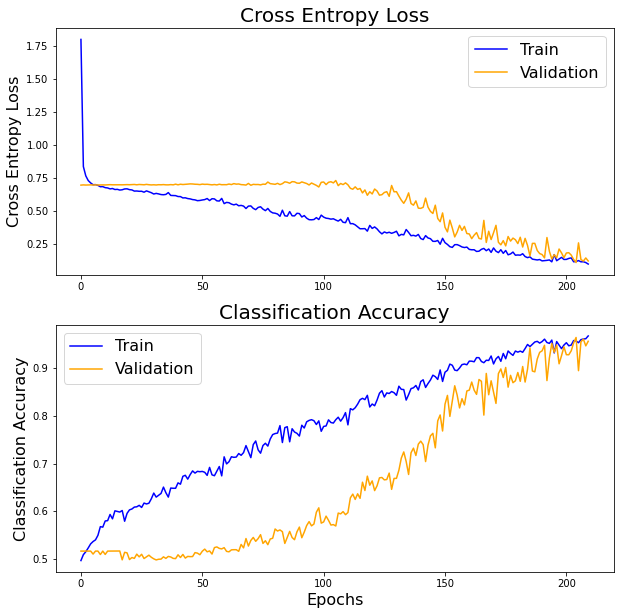

In [71]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title('Cross Entropy Loss', fontsize = 20)
ax[0].plot(history.history['loss'], color='blue', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set_ylabel('Cross Entropy Loss', fontsize = 16)
ax[0].legend(fontsize = 16)

ax[1].set_title('Classification Accuracy', fontsize = 20)
ax[1].plot(history.history['accuracy'], color='blue', label='Train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[1].set_ylabel('Classification Accuracy', fontsize = 16)
ax[1].set_xlabel('Epochs', fontsize = 16)
ax[1].legend(fontsize = 16)

plt.show()

# Prediction

In [72]:
X_test_ = pd.concat([pd.DataFrame(X_test[:-1,])], axis=1)
X_test_.shape

(725, 10)

In [73]:
725/29

25.0

In [74]:
timesteps = 29
samples = int(X_test_.shape[0]/timesteps)
features = len(cols)

X_test_reshape = np.array(X_test_).reshape(samples, timesteps, features)
#y_test_reshape = np.array(y_test_).reshape(samples, timesteps, 1)
X_test_reshape.shape

(25, 29, 10)

In [75]:
X_train_reshape.shape

(226, 29, 10)

In [76]:
model.predict(X_test_reshape).reshape(X_test_reshape.shape[0]*X_test_reshape.shape[1],1).shape

(725, 1)

In [77]:
res = list(model.predict(X_test_reshape).reshape(X_test_reshape.shape[0]*X_test_reshape.shape[1],1)[:,0])

test = train_test.loc[train_test.Date >'2019-05-30']
res.append(0)

test['proba'] = res
test['pred'] = test['proba'] > 0.5
test['Target'] = test['Target'].astype(int)
test['pred'] = test['pred'].astype(int).astype('category')
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Date,Open,High,Low,Close,Adj Close,Volume,Target,TRAIN_TEST,day,month,quarter,week,proba,pred
6557,2019-06-05,9136799,9173400,9095000,9150500,9150500,158753000,0,1,5,2,2,23,0.377301,0
6558,2019-06-06,9169200,9246200,9136700,9169200,9169200,212720900,0,1,6,3,2,23,0.524364,1
6559,2019-06-07,9186700,9261400,9185700,9236099,9236099,150664700,0,1,7,4,2,23,0.482709,0
6560,2019-06-10,9284200,9302200,9248099,9294099,9294099,102323700,0,1,10,0,2,24,0.697544,1
6561,2019-06-11,9288599,9332500,9273400,9282099,9282099,144701200,0,1,11,1,2,24,0.118943,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,2022-03-25,8314099,8363200,8286500,8330599,8330599,156189000,0,1,25,4,1,12,0.000185,0
7279,2022-03-28,8354400,8485700,8354400,8365599,8365599,167961800,0,1,28,0,1,13,0.000777,0
7280,2022-03-29,8451000,8621000,8419700,8614599,8614599,257812200,0,1,29,1,1,13,0.865116,1
7281,2022-03-30,8583299,8597400,8508900,8550599,8550599,185389000,0,1,30,2,1,13,0.961039,1


In [80]:
def all_metrics(y, y_pred):
        print(' Accuracy: ',accuracy_score(y, y_pred))
        print(' Precision: ',precision_score(y, y_pred))
        print(' Recall: ',recall_score(y, y_pred))
        print(' F1-score :',f1_score(y, y_pred))

In [81]:
all_metrics(test['Target'], test['pred'])

 Accuracy:  0.42424242424242425
 Precision:  0.0
 Recall:  0.0
 F1-score : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
